# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Recherche de l'`architecture` la plus adaptée](#ARCHI)
    * [2.1 `Archi-REF` Bi-LSTM 32 + Dropout 0.5](#ARCHI_REF)
    * [2.2 `Archi-000` Dense 32 + Dropout 0.5](#ARCHI_000)
    * [2.3 `Archi-100` Simple RNN 32 + Dropout 0.5](#ARCHI_100)
    * [2.4 `Archi-200` LSTM 32 + Dropout 0.5](#ARCHI_200)
    * [2.5 `Archi-300` GRU 32 + Dropout 0.5](#ARCHI_300)
    * [2.6 `Archi-201` Bi-LSTM 64 + Dropout 0.5](#ARCHI_201)
    * [2.7 `Archi-202` Bi-LSTM 64 + Dense 24](#ARCHI_202)
    * [2.8 `Archi-301` Bi-GRU 64 + Dropout 0.5](#ARCHI_301)
    * [2.9 `Archi-302` Bi-GRU 64 + Dense 24](#ARCHI_302)
    * [2.10 `Archi-401` Bi-LSTM 32 + Dense 10](#ARCHI_401)
    * [2.11 `Archi-402` Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1](#ARCHI_402)
    * [2.12 `Archi-403` Dense 128 + Dropout 0.2 + Dense 64 + Dropout 0.2 + Dense 32 + Dropout 0.1](#ARCHI_403)
    * [2.13 Comparaison des scores](#ARCHI_scores)

In [1]:
import time
import pathlib
import gzip

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dagshub import dagshub_logger, DAGsHubLogger

try:
    from tensorflow.keras.layers import TextVectorization
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-08-08 15:28:12.681577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 15:28:12.681600: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-08-08 15:28:17.255848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-08 15:28:17.255886: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-08 15:28:17.255906: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valkea-XPS): /proc/driver/nvidia/version does not exist


---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

### Chargeons quelques fonctions *maison* pour entrainer et évaluer les modèles, et initialisons un fichier pour enregistrer les scores
Ces fonctions ont été déportées dans le fichier classification_utils.py pour allèger le notebook

In [3]:
# Load classification helpers' functions & initialize a file to log the models' scores
from classification_utils import fit_model, get_scores, init_scores, find_best_threshold
init_scores("data/scores_NN_SelectArchitecture.csv")

### Chargeons le jeu de données et préparons un `échantillon de travail` représentatif

In [4]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'lemmas_not_filtered'],
    encoding='ISO-8859-1',
    #nrows=100000,
)
data_work.rename(columns={'lemmas_not_filtered':'text'}, inplace=True)
display(data_work.head(), data_work.shape)

# Select samples
sample_size = 100000
data_work = data_work.groupby('target', group_keys=False).apply(lambda x: x.sample(sample_size//2, random_state=random_seed))
display(data_work.head(), data_work.shape)

,target,text
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...
2,0,I dive many time for the ball . manage to save...
3,0,my whole body feel itchy and like its on fire
4,0,"no , it be not behave at all . I be mad . why ..."


(1452791, 2)

,target,text
469259,0,I do not have a background for my twitter stre...
152271,0,I do many thing but miss tweet
597612,0,most probably - eww all that pasty white skin ...
708306,0,"ohh , how bad I sleep"
59100,0,"hell yeah u be texte I I remember , I be at my..."


(100000, 2)

In [5]:
data_work.target.value_counts(dropna=False)

0    50000
1    50000
Name: target, dtype: int64

### Définissons les différentes `architectures RNN` que nous aimerions comparer

#### L'architecture utilisée sur les précèdents notebooks

In [6]:
# P.336 livre "Deep Learning with Python 2nd edition"
def architectureREF(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 32 + Dropout 0.5"

In [83]:
# P.323 livre "Deep Learning with Python 2nd edition"
def architecture000(f_opti, f_loss, f_metrics, embedding):
        
    max_tokens = 60
    inputs = keras.Input(shape=(max_tokens,), dtype="int64")
    
    #x = embedding(inputs)
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Dense 32 + Dropout 0.5"

#### Simple RNN / LSTM / GRU

In [8]:
# Simple RNN
def architecture100(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.SimpleRNN(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Simple RNN 32 + Dropout 0.5"

In [9]:
# LSTM 32
def architecture200(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.LSTM(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "LSTM 32 + Dropout 0.5"

In [10]:
# GRU 32
def architecture300(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.GRU(32)(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "GRU 32 + Dropout 0.5"

#### Birectional RNN / LSTM / GRU

In [11]:
def architecture201(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 + Dropout 0.5"

In [12]:
# https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/
def architecture202(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 + Dense 24"

In [13]:
def architecture301(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.GRU(64))(x)
    #x = layers.Dense(24, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-GRU 64 + Dropout 0.5"

In [14]:
def architecture302(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.GRU(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    # x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-GRU 64 + Dense 24"

#### Quelques architectures trouvées dans mes lectures

In [15]:
# https://www.embedded-robotics.com/sentiment-analysis-using-lstm/
def architecture401(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(10, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 32 + Dense 10"

In [16]:
# https://www.analyticsvidhya.com/blog/2021/08/sentiment-analysis-using-bidirectional-stacked-lstm/
def architecture402(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, input_shape=(None, 1)))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1"

In [ ]:
# Own archi base on P.349 livre "Deep Learning with Python 2nd edition"
def architecture403(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Dense(128)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32)(x)
    x = layers.Dropout(0.1)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model, "Dense 128 + Dropout 0.2 + Dense 64 + Dropout 0.2 + Dense 32 + Dropout 0.1"

### Définissons les fonctions utiles à l'`embedding`

In [18]:
## EMBEDDING ##

from gensim.models import KeyedVectors
import gensim.downloader as api

def load_gensim_embedding(embedding_name, binary=False):
    
    embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
    try:
        if embedding_path.is_file():
            print(f"Loading from {embedding_path}")
            embedding_model = KeyedVectors.load_word2vec_format(embedding_path, binary=binary)
        else:
            print("Loading from the Git repos with API")
            embedding_model = api.load(embedding_name)
            
        return embedding_model
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")
        
def convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim=100):
    
    hits = 0
    misses = 0
    misses_list = []
    
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    
    embedding_matrix = np.zeros((max_tokens, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_tokens:
            try:
                embedding_vector = embeddings_index.get_vector(word)
            except AttributeError:
                embedding_vector = embeddings_index.get(word)
            except KeyError:
                embedding_vector = None
        if embedding_vector is not None:
            hits += 1
            embedding_matrix[i] = embedding_vector
        else:
            misses += 1
            misses_list.append(word)
            
    print(f"Converted {hits} words, and couldn't find {misses} words")
    print(f"Missing words: {misses_list}")
            
    return embedding_matrix

### Définissons les `fonctions et paramètres commun` à l'entrainement des différents modèles que l'on veut tester

In [38]:
# DagsHub 

def save_hyperparameters_to_dagshub(dlogger, model_name, archi_desc, layers, batch_size, sample_size):    
    dlogger.log_hyperparams(model_name=model_name)
    dlogger.log_hyperparams(archi_desc=archi_desc)
    dlogger.log_hyperparams(layers=layers)
    dlogger.log_hyperparams(batch_size=batch_size)
    dlogger.log_hyperparams(sample_size=sample_size)
    
def save_metrics_to_dagshub(dlogger, scores, best_threshold, history, step_num=1000, close=True):
    dlogger.log_metrics(scores, step_num=step_num)
    dlogger.log_metrics(best_threshold=best_threshold, step_num=step_num)
    add_scores_to_dagshub(dlogger, history)

def get_layers_for_dagshub(model):
    
    layers_infos = []
    
    def search(layer):
        layer = dict(layer)
        
        nonlocal layers_infos
        
        if 'config' in layer:
    
            #if 'name' in layer['config']:
            #    print(" name:", layer['config']['name'])
            conf = {}
            if 'units' in layer['config']:
                conf["units"] = layer['config']['units']
            if 'output_dim' in layer['config']:
                conf['output_dim'] = layer['config']['output_dim']
            if 'rate' in layer['config']:
                conf['rate'] = layer['config']['rate']
            
            layers_infos.append((layer['class_name'], conf))
            
            if 'layer' in layer['config']:
                search(layer['config']['layer'])
        
    for layer in model.get_config()['layers']:
        search(layer)
        
    return layers_infos


def add_scores_to_dagshub(dlogger, history):
    for epoch, loss, accuracy, val_loss, val_accuracy in zip(
        history.epoch, 
        history.history['loss'], 
        history.history['accuracy'], 
        history.history['val_loss'], 
        history.history['val_accuracy']):
        scores = {
            'loss':loss, 
            'accuracy':accuracy, 
            'val_loss':val_loss, 
            'val_accuracy':val_accuracy
        }
        dlogger.log_metrics(scores, step_num=epoch) 

In [20]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [21]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=5,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es]

In [22]:
batch_size=1024

### Divisons le jeu de données en `Train`, `Valid` et `Test` sets

In [23]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data_work['text'], data_work['target'], test_size=0.2, random_state=random_seed, stratify=data_work['target'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=random_seed, stratify=y_train_full)

assert X_train.shape[0] + X_valid.shape[0] + X_test.shape[0] == data_work.shape[0]
assert y_train.shape[0] + y_valid.shape[0] + y_test.shape[0] == data_work.shape[0]

print(f"X_train: {X_train.shape} + X_valid: {X_valid.shape} + X_test: {X_test.shape}")
print(f"y_train: {X_train.shape} + y_valid: {X_valid.shape} + y_test: {X_test.shape}")

X_train: (60000,) + X_valid: (20000,) + X_test: (20000,)
y_train: (60000,) + y_valid: (20000,) + y_test: (20000,)


---
---
# 2. Recherche de l'`architecture` la plus adaptée <a class="anchor" id="ARCHI"></a> [⇪](#menu)

### Préparons des train, valid et test set avec l'embedding retenu [Ngram=1 | int | GloveTwitter200-gensim Embedding + MASK + NOT Trainable]

#### Standardize & Tokenize

In [25]:
max_length = 60
max_tokens = 20000

text_vectorizationB7 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [26]:
text_vectorizationB7.adapt(list(data_work.text), True)

In [27]:
print(text_vectorizationB7.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [28]:
X_train_ready = text_vectorizationB7(X_train)
X_valid_ready = text_vectorizationB7(X_valid)
X_test_ready = text_vectorizationB7(X_test)

In [29]:
X_train[:2]

888559               dh way too crazy ... I need a xanax ..
500657    I too ... bur with engineering imma be here 5 ...
Name: text, dtype: object

In [30]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[ 3783,   122,    48,   414,     2,    76,     6, 13712,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    2,    48, 10568,    25, 12742,  1210,     3,    86,   270,
          913,   525,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [31]:
embeddings_index = load_gensim_embedding("glove-twitter-200")

Loading from /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/glove-twitter-200.gz


In [32]:
embedding_dim = 200
vocabulary = text_vectorizationB7.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 17511 words, and couldn't find 2489 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '6', '10', '8', '7', '30', '100', '20', '12', '9', '1st', '15', '11', '2day', '2nd', '50', '25', 'Ã¢Â\x99', 'Â«', '16', 'b4', '18', '2009', '3rd', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', '2morrow', '80', 'e3', '0', '14', '3d', 'Â°', '2nite', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'booo', '33', '70', '09', '1000', 'ughhh', 'f1', '22', '4th', 'gr8', 'boooo', '6th', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'ps3', '2moro', '19', 'lvatt', '45', '2010', '300', '9th', '5th', '333', '35', 'iÃ¢Â´m', '3gs', '400', '360', 'Ã¯Â¿Â½', 'spymaster', 'itÃ¢Â´s', '430', '7th', '630', '23', '18th', 'yayyy', 'toooo', 'iÃ¯Â¿Â½m', 'Â¦', 'ohhhh', 'mp3', '830', '2night', '26', 'o2', 'every1', '8th', '530', '32', '28', '15th', 'twitterberry', 'asot400', '99', '930', '55', '10th', 'mcflyforgermany', '29', '27', '1230', 'marsiscome', '13th', 'ewww', 'booooo', '730', '20th', 'youuuu', '

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.056404  ,  0.49535999,  0.18438999, ...,  0.63598001,
        -0.18880001, -0.035558  ],
       ...,
       [-0.096356  ,  1.2062    ,  0.23548   , ...,  0.94726998,
         0.16539   ,  0.028865  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21808   , -0.12392   ,  0.11099   , ...,  0.75081998,
        -0.15744001, -0.11758   ]])

---
## 2.1 `Archi-REF` Bi-LSTM 32 + Dropout 0.5 *(l'architecture de référence utilisée dans les autres notebooks)* <a class="anchor" id="ARCHI_REF"></a> [⇪](#menu)

In [33]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [34]:
model_name = "ArchiREF"
model, archi_desc = architectureREF("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               59648     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 4,059,713
Trainable params: 59,713
Non-trainabl

#### Définissons un logger DagsHub pour enregistrer notre essai

In [36]:
dagslogger = DAGsHubLogger()

In [39]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [40]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.6843
Epoch 1: val_accuracy improved from -inf to 0.74845, saving model to models/ArchiREF.keras
59/59 [==============================] - 32s 422ms/step - loss: 0.5874 - accuracy: 0.6843 - val_loss: 0.5154 - val_accuracy: 0.7484
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.7561
Epoch 2: val_accuracy improved from 0.74845 to 0.76770, saving model to models/ArchiREF.keras
59/59 [==============================] - 24s 414ms/step - loss: 0.5019 - accuracy: 0.7561 - val_loss: 0.4834 - val_accuracy: 0.7677
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4801 - accuracy: 0.7696
Epoch 3: val_accuracy improved from 0.76770 to 0.77605, saving model to models/ArchiREF.keras
59/59 [==============================] - 24s 415ms/step - loss: 0.4801 - accuracy: 0.7696 - val_loss: 0.4690 - val_accuracy: 0.7760
Epoch 4/100
59/59 [=====================

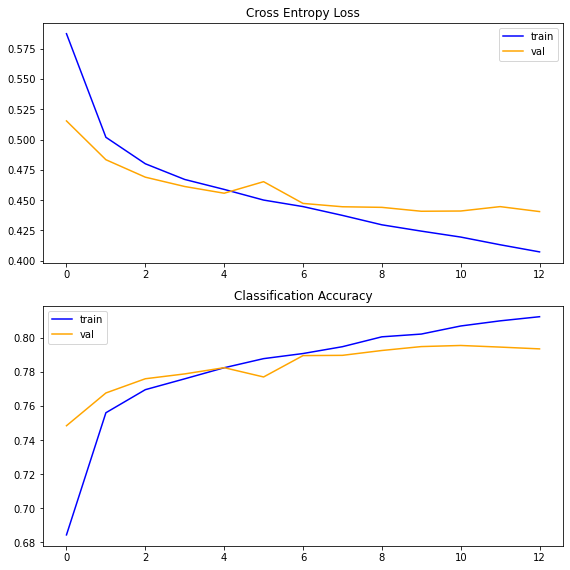

In [41]:
summarize_diagnostics(history)

### Evaluate

In [42]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [43]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 10s 13ms/step - loss: 0.4410 - accuracy: 0.7956


[0.4410381317138672, 0.7955999970436096]

In [44]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 3s 3s/step


array([[0.06537156],
       [0.955713  ]], dtype=float32)

625/625 [==============================] - 9s 15ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- ArchiREF ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8765
                  F1 : 0.7908
            ACCURACY : 0.7956
           PRECISION : 0.8099
              RECALL : 0.7726
   AVERAGE_PRECISION : 0.8795

       TRAINING-TIME : 339.8483
      INFERENCE-TIME : 9.5038

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.82      0.80     10000
Prediction = 1       0.81      0.77      0.79     10000

      accuracy      

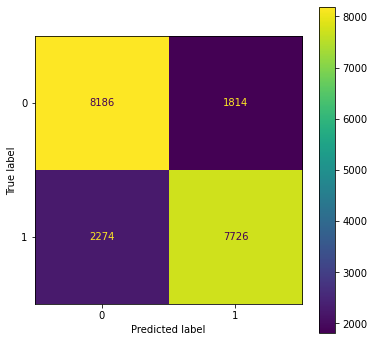

--- ROC AUC ---------------------------------------------------------------------------------------- 



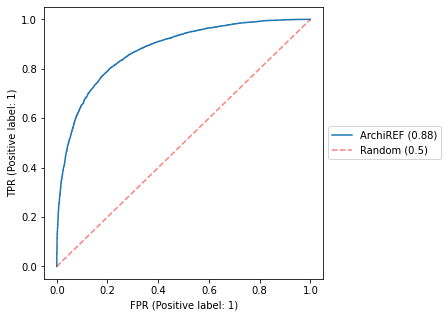

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



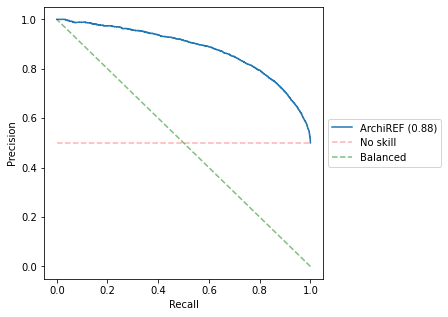

In [45]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [46]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 8s 13ms/step
The best Accuracy score (0.7973) for this model is reached with a threshold of 0.468


625/625 [==============================] - 8s 12ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- ArchiREF [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8765
                  F1 : 0.7953
            ACCURACY : 0.7956
           PRECISION : 0.7968
              RECALL : 0.7937
   AVERAGE_PRECISION : 0.8795

       TRAINING-TIME : 339.8483
      INFERENCE-TIME : 8.0228

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.80      0.80     10000
Prediction = 1       0.80      0.79      0.80     10000

      accuracy      

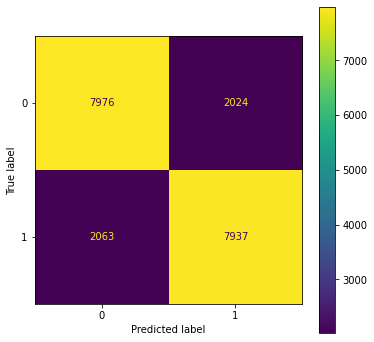

In [47]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [48]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [49]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760


---
## 2.2 `Archi-000` Dense 32 + Dropout 0.5 <a class="anchor" id="ARCHI_000"></a> [⇪](#menu)

In [51]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [84]:
model_name = "Archi000"
model, archi_desc = architecture000("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [85]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                1952      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 predictions (Dense)         (None, 1)                 33        
                                                                 
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________


#### Définissons un logger DagsHub pour enregistrer notre essai

In [86]:
dagslogger = DAGsHubLogger()

In [87]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [88]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
42/59 [====================>.........] - ETA: 0s - loss: 320.1115 - accuracy: 0.5045
Epoch 1: val_accuracy improved from -inf to 0.50750, saving model to models/Archi000.keras
59/59 [==============================] - 1s 6ms/step - loss: 293.4107 - accuracy: 0.5048 - val_loss: 84.4825 - val_accuracy: 0.5075
Epoch 2/100
43/59 [====================>.........] - ETA: 0s - loss: 168.3755 - accuracy: 0.5004
Epoch 2: val_accuracy improved from 0.50750 to 0.51005, saving model to models/Archi000.keras
59/59 [==============================] - 0s 4ms/step - loss: 157.0745 - accuracy: 0.4999 - val_loss: 45.7035 - val_accuracy: 0.5100
Epoch 3/100
40/59 [===================>..........] - ETA: 0s - loss: 91.2727 - accuracy: 0.5054 
Epoch 3: val_accuracy did not improve from 0.51005
59/59 [==============================] - 0s 3ms/step - loss: 82.3690 - accuracy: 0.5058 - val_loss: 25.8284 - val_accuracy: 0.5084
Epoch 4/100
58/59 [============================>.] - ETA: 0s - loss: 40.1912 -

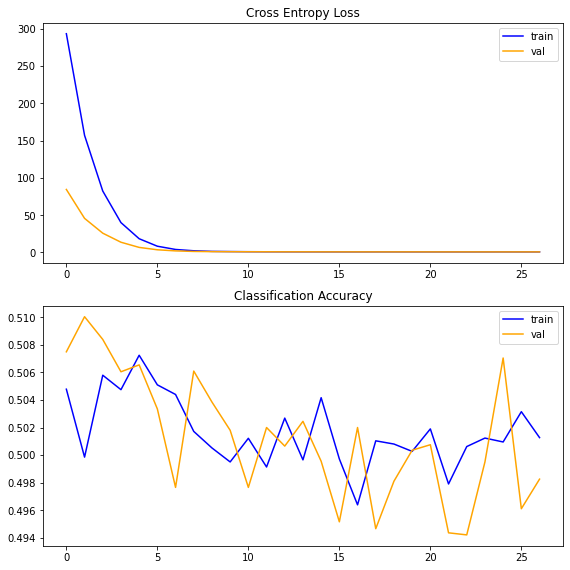

In [89]:
summarize_diagnostics(history)

### Evaluate

In [90]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [91]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 1s 1ms/step - loss: 45.7035 - accuracy: 0.5100


[45.703460693359375, 0.5100499987602234]

In [92]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 0s 49ms/step


array([[0.92988944],
       [0.5382266 ]], dtype=float32)

625/625 [==============================] - 1s 1ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi000 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.5050
                  F1 : 0.5395
            ACCURACY : 0.5101
           PRECISION : 0.5089
              RECALL : 0.5739
   AVERAGE_PRECISION : 0.5035

       TRAINING-TIME : 6.3667
      INFERENCE-TIME : 0.8235

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.51      0.45      0.48     10000
Prediction = 1       0.51      0.57      0.54     10000

      accuracy         

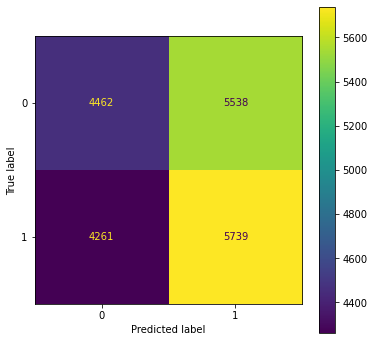

--- ROC AUC ---------------------------------------------------------------------------------------- 



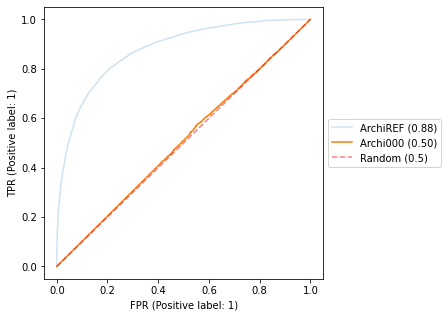

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



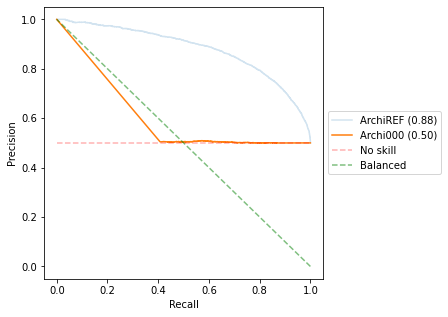

In [93]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [94]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 1s 991us/step
The best Accuracy score (0.50505) for this model is reached with a threshold of 0.453


625/625 [==============================] - 1s 939us/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi000 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.5050
                  F1 : 0.5406
            ACCURACY : 0.5099
           PRECISION : 0.5087
              RECALL : 0.5767
   AVERAGE_PRECISION : 0.5035

       TRAINING-TIME : 6.3667
      INFERENCE-TIME : 0.7814

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.51      0.44      0.47     10000
Prediction = 1       0.51      0.58      0.54     10000

      accuracy       

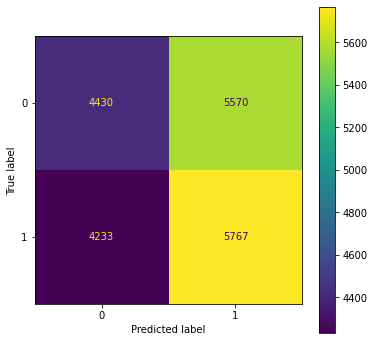

In [95]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [96]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [97]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419


---
## 2.3 `Archi-100` Simple RNN 32 + Dropout 0.5 <a class="anchor" id="ARCHI_100"></a> [⇪](#menu)

In [98]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [99]:
model_name = "Archi100"
model, archi_desc = architecture100("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [100]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                7456      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 predictions (Dense)         (None, 1)                 33        
                                                                 
Total params: 4,007,489
Trainable params: 7,489
Non-trainable params: 4,000,000
_____________________________________________

#### Définissons un logger DagsHub pour enregistrer notre essai

In [101]:
dagslogger = DAGsHubLogger()

In [102]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [103]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.5758
Epoch 1: val_accuracy improved from -inf to 0.68985, saving model to models/Archi100.keras
59/59 [==============================] - 12s 179ms/step - loss: 0.7177 - accuracy: 0.5758 - val_loss: 0.5860 - val_accuracy: 0.6898
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.7034
Epoch 2: val_accuracy improved from 0.68985 to 0.74700, saving model to models/Archi100.keras
59/59 [==============================] - 9s 154ms/step - loss: 0.5830 - accuracy: 0.7034 - val_loss: 0.5232 - val_accuracy: 0.7470
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.5397 - accuracy: 0.7360
Epoch 3: val_accuracy improved from 0.74700 to 0.75935, saving model to models/Archi100.keras
59/59 [==============================] - 9s 154ms/step - loss: 0.5397 - accuracy: 0.7360 - val_loss: 0.5073 - val_accuracy: 0.7594
Epoch 4/100
59/59 [=======================

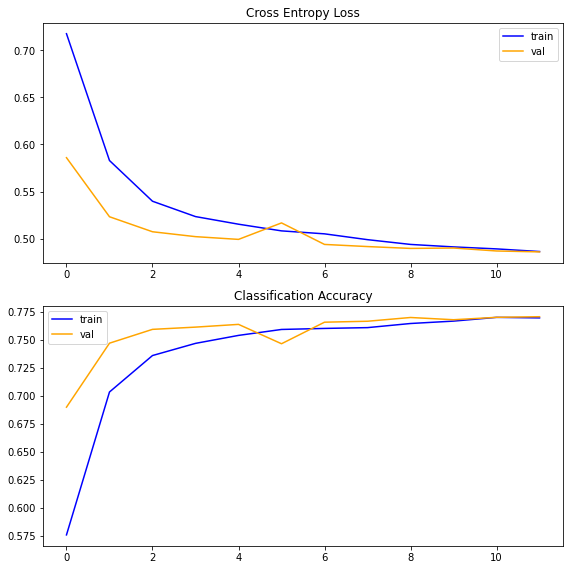

In [104]:
summarize_diagnostics(history)

### Evaluate

In [105]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [106]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 4s 6ms/step - loss: 0.4859 - accuracy: 0.7707


[0.48590171337127686, 0.7706500291824341]

In [107]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 0s 159ms/step


array([[0.15512349],
       [0.82912254]], dtype=float32)

625/625 [==============================] - 4s 6ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi100 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8469
                  F1 : 0.7703
            ACCURACY : 0.7706
           PRECISION : 0.7715
              RECALL : 0.7690
   AVERAGE_PRECISION : 0.8475

       TRAINING-TIME : 105.5795
      INFERENCE-TIME : 4.1896

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.77      0.77     10000
Prediction = 1       0.77      0.77      0.77     10000

      accuracy       

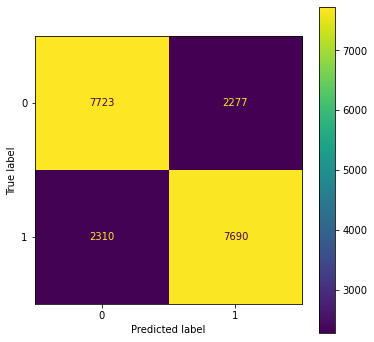

--- ROC AUC ---------------------------------------------------------------------------------------- 



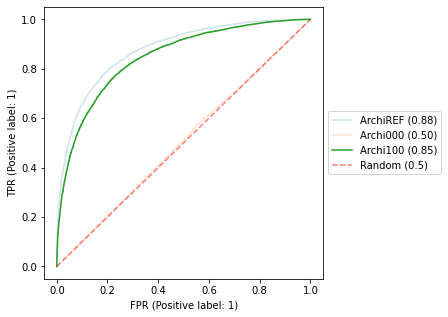

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



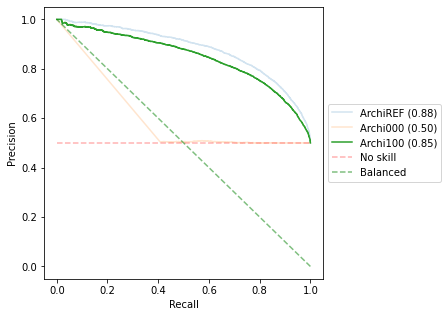

In [108]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [109]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 4s 6ms/step
The best Accuracy score (0.77105) for this model is reached with a threshold of 0.556


625/625 [==============================] - 4s 6ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi100 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8469
                  F1 : 0.7556
            ACCURACY : 0.7665
           PRECISION : 0.7925
              RECALL : 0.7220
   AVERAGE_PRECISION : 0.8475

       TRAINING-TIME : 105.5795
      INFERENCE-TIME : 3.9682

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.74      0.81      0.78     10000
Prediction = 1       0.79      0.72      0.76     10000

      accuracy       

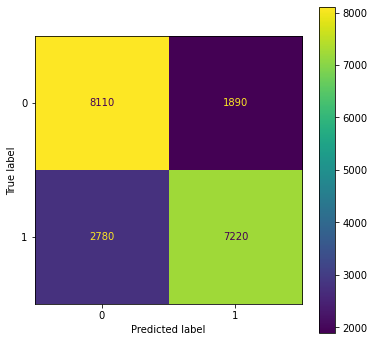

In [110]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [111]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [112]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156


---
## 2.4 `Archi-200` LSTM 32 + Dropout 0.5 <a class="anchor" id="ARCHI_200"></a> [⇪](#menu)

In [114]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [115]:
model_name = "Archi200"
model, archi_desc = architecture200("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [116]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 32)                29824     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 predictions (Dense)         (None, 1)                 33        
                                                                 
Total params: 4,029,857
Trainable params: 29,857
Non-trainable params: 4,000,000
____________________________________________

#### Définissons un logger DagsHub pour enregistrer notre essai

In [117]:
dagslogger = DAGsHubLogger()

In [118]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [119]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.6616
Epoch 1: val_accuracy improved from -inf to 0.74230, saving model to models/Archi200.keras
59/59 [==============================] - 21s 286ms/step - loss: 0.6095 - accuracy: 0.6616 - val_loss: 0.5266 - val_accuracy: 0.7423
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.7536
Epoch 2: val_accuracy improved from 0.74230 to 0.76340, saving model to models/Archi200.keras
59/59 [==============================] - 17s 282ms/step - loss: 0.5120 - accuracy: 0.7536 - val_loss: 0.4922 - val_accuracy: 0.7634
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.7674
Epoch 3: val_accuracy improved from 0.76340 to 0.77265, saving model to models/Archi200.keras
59/59 [==============================] - 17s 298ms/step - loss: 0.4903 - accuracy: 0.7674 - val_loss: 0.4772 - val_accuracy: 0.7727
Epoch 4/100
59/59 [=====================

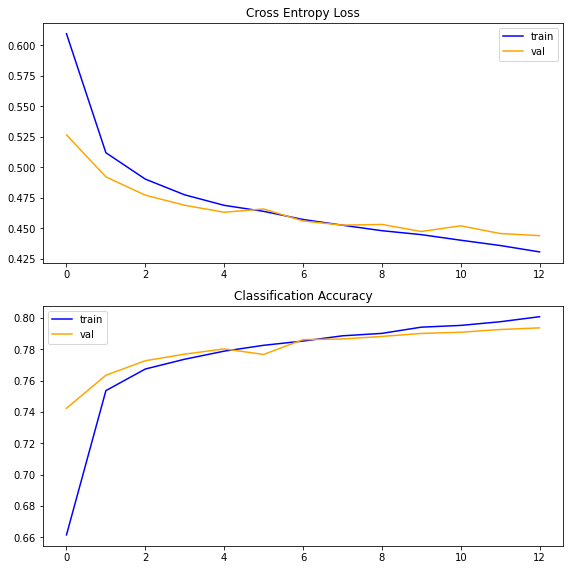

In [120]:
summarize_diagnostics(history)

### Evaluate

In [121]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [122]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 8s 11ms/step - loss: 0.4440 - accuracy: 0.7936


[0.44401103258132935, 0.7936000227928162]

In [123]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 1s 1s/step


array([[0.05564439],
       [0.9427956 ]], dtype=float32)

625/625 [==============================] - 6s 10ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi200 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8744
                  F1 : 0.7922
            ACCURACY : 0.7936
           PRECISION : 0.7976
              RECALL : 0.7868
   AVERAGE_PRECISION : 0.8773

       TRAINING-TIME : 219.1697
      INFERENCE-TIME : 6.5726

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.80      0.79     10000
Prediction = 1       0.80      0.79      0.79     10000

      accuracy      

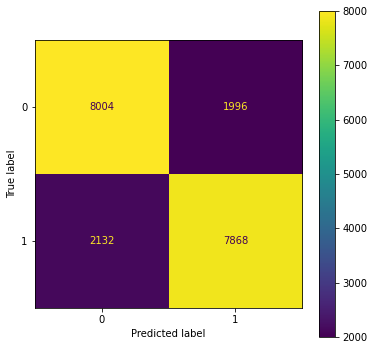

--- ROC AUC ---------------------------------------------------------------------------------------- 



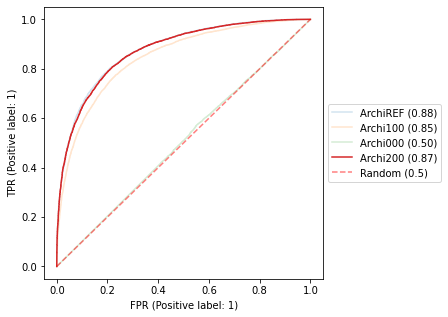

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



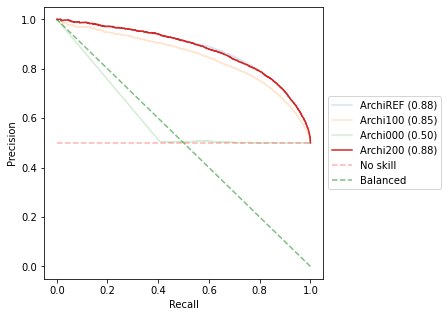

In [124]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [125]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 6s 10ms/step
The best Accuracy score (0.7955) for this model is reached with a threshold of 0.487


625/625 [==============================] - 7s 11ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi200 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8744
                  F1 : 0.7940
            ACCURACY : 0.7935
           PRECISION : 0.7922
              RECALL : 0.7958
   AVERAGE_PRECISION : 0.8773

       TRAINING-TIME : 219.1697
      INFERENCE-TIME : 7.0335

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.79      0.79     10000
Prediction = 1       0.79      0.80      0.79     10000

      accuracy      

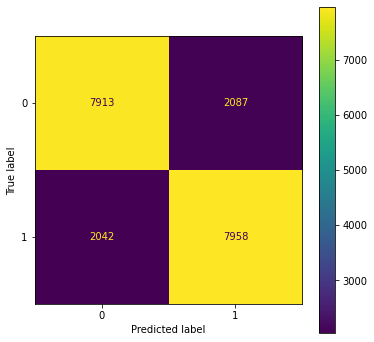

In [126]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [127]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [128]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156
6,Archi200,0.500,None,0.874350,0.877319,0.792187,0.79360,0.797648,0.7868,7868,8004,1996,2132,219.169741,6.572566
7,Archi200 [w. threshold],0.487,None,0.874350,0.877319,0.794013,0.79355,0.792235,0.7958,7958,7913,2087,2042,219.169741,7.033490


---
## 2.5 `Archi-300` GRU 32 + Dropout 0.5 <a class="anchor" id="ARCHI_300"></a> [⇪](#menu)

In [130]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [131]:
model_name = "Archi300"
model, archi_desc = architecture300("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [132]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 gru (GRU)                   (None, 32)                22464     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 predictions (Dense)         (None, 1)                 33        
                                                                 
Total params: 4,022,497
Trainable params: 22,497
Non-trainable params: 4,000,000
____________________________________________

#### Définissons un logger DagsHub pour enregistrer notre essai

In [133]:
dagslogger = DAGsHubLogger()

In [134]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [135]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.6322
Epoch 1: val_accuracy improved from -inf to 0.72325, saving model to models/Archi300.keras
59/59 [==============================] - 21s 294ms/step - loss: 0.6332 - accuracy: 0.6322 - val_loss: 0.5465 - val_accuracy: 0.7232
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.7473
Epoch 2: val_accuracy improved from 0.72325 to 0.76615, saving model to models/Archi300.keras
59/59 [==============================] - 17s 282ms/step - loss: 0.5175 - accuracy: 0.7473 - val_loss: 0.4875 - val_accuracy: 0.7661
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.7701
Epoch 3: val_accuracy improved from 0.76615 to 0.77660, saving model to models/Archi300.keras
59/59 [==============================] - 16s 279ms/step - loss: 0.4875 - accuracy: 0.7701 - val_loss: 0.4734 - val_accuracy: 0.7766
Epoch 4/100
59/59 [=====================

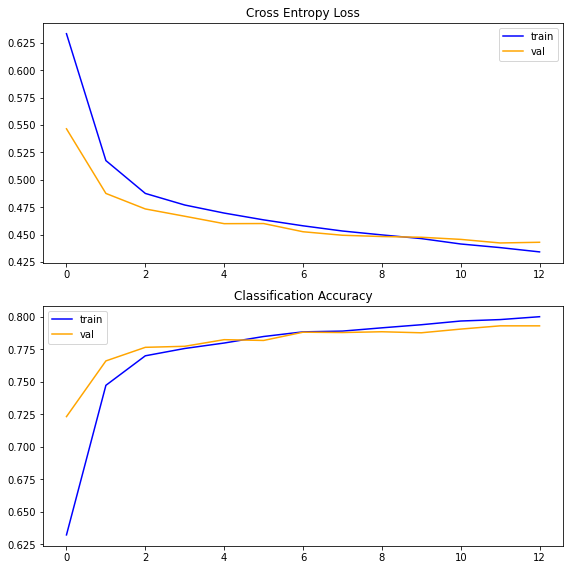

In [136]:
summarize_diagnostics(history)

### Evaluate

In [137]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [138]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 7s 9ms/step - loss: 0.4423 - accuracy: 0.7932


[0.44233524799346924, 0.793150007724762]

In [139]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 1s 1s/step


array([[0.05679736],
       [0.927152  ]], dtype=float32)

625/625 [==============================] - 6s 9ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi300 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8751
                  F1 : 0.7896
            ACCURACY : 0.7932
           PRECISION : 0.8034
              RECALL : 0.7763
   AVERAGE_PRECISION : 0.8785

       TRAINING-TIME : 219.3377
      INFERENCE-TIME : 5.7284

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.81      0.80     10000
Prediction = 1       0.80      0.78      0.79     10000

      accuracy       

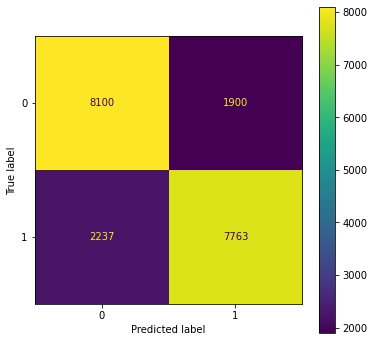

--- ROC AUC ---------------------------------------------------------------------------------------- 



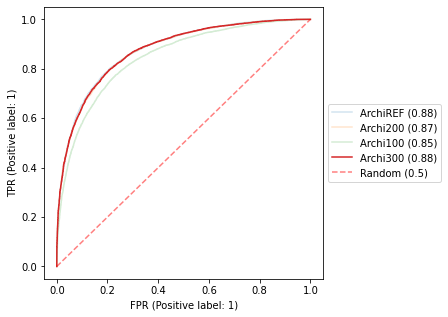

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



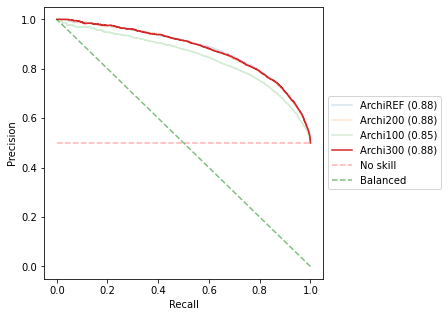

In [140]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [141]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 6s 9ms/step
The best Accuracy score (0.79615) for this model is reached with a threshold of 0.522


625/625 [==============================] - 6s 10ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi300 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8751
                  F1 : 0.7852
            ACCURACY : 0.7919
           PRECISION : 0.8110
              RECALL : 0.7610
   AVERAGE_PRECISION : 0.8785

       TRAINING-TIME : 219.3377
      INFERENCE-TIME : 6.5687

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.82      0.80     10000
Prediction = 1       0.81      0.76      0.79     10000

      accuracy      

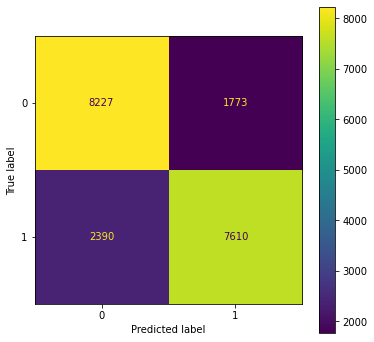

In [142]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [143]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [144]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156
6,Archi200,0.500,None,0.874350,0.877319,0.792187,0.79360,0.797648,0.7868,7868,8004,1996,2132,219.169741,6.572566
7,Archi200 [w. threshold],0.487,None,0.874350,0.877319,0.794013,0.79355,0.792235,0.7958,7958,7913,2087,2042,219.169741,7.033490
8,Archi300,0.500,None,0.875135,0.878472,0.789605,0.79315,0.803374,0.7763,7763,8100,1900,2237,219.337739,5.728404
9,Archi300 [w. threshold],0.522,None,0.875135,0.878472,0.785224,0.79185,0.811041,0.7610,7610,8227,1773,2390,219.337739,6.568661


---
## 2.6 `Archi-201` Bi-LSTM 64 + Dropout 0.5 <a class="anchor" id="ARCHI_201"></a> [⇪](#menu)

In [146]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [147]:
model_name = "Archi201"
model, archi_desc = architecture201("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [148]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 4,135,809
Trainable params: 135,809
Non-train

#### Définissons un logger DagsHub pour enregistrer notre essai

In [149]:
dagslogger = DAGsHubLogger()

In [150]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [152]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7128
Epoch 1: val_accuracy improved from -inf to 0.75525, saving model to models/Archi201.keras
59/59 [==============================] - 55s 936ms/step - loss: 0.5577 - accuracy: 0.7128 - val_loss: 0.4960 - val_accuracy: 0.7552
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.7640
Epoch 2: val_accuracy improved from 0.75525 to 0.76970, saving model to models/Archi201.keras
59/59 [==============================] - 56s 948ms/step - loss: 0.4884 - accuracy: 0.7640 - val_loss: 0.4750 - val_accuracy: 0.7697
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.7760
Epoch 3: val_accuracy improved from 0.76970 to 0.77740, saving model to models/Archi201.keras
59/59 [==============================] - 46s 780ms/step - loss: 0.4702 - accuracy: 0.7760 - val_loss: 0.4635 - val_accuracy: 0.7774
Epoch 4/100
59/59 [=====================

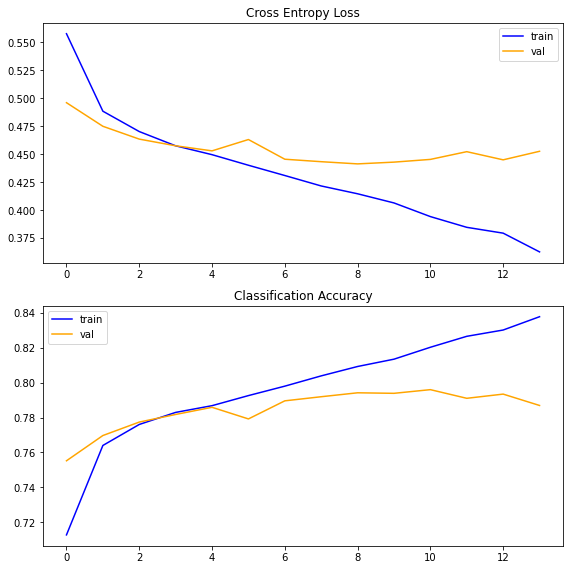

In [153]:
summarize_diagnostics(history)

### Evaluate

In [154]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [155]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 11s 16ms/step - loss: 0.4453 - accuracy: 0.7959


[0.4453451633453369, 0.7959499955177307]

In [156]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 2s 2s/step


array([[0.04986503],
       [0.9546396 ]], dtype=float32)

625/625 [==============================] - 10s 17ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi201 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8760
                  F1 : 0.7922
            ACCURACY : 0.7960
           PRECISION : 0.8070
              RECALL : 0.7779
   AVERAGE_PRECISION : 0.8789

       TRAINING-TIME : 685.3491
      INFERENCE-TIME : 10.5846

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.81      0.80     10000
Prediction = 1       0.81      0.78      0.79     10000

      accuracy    

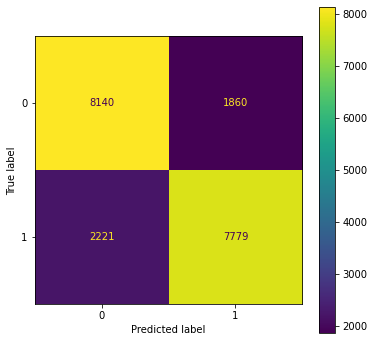

--- ROC AUC ---------------------------------------------------------------------------------------- 



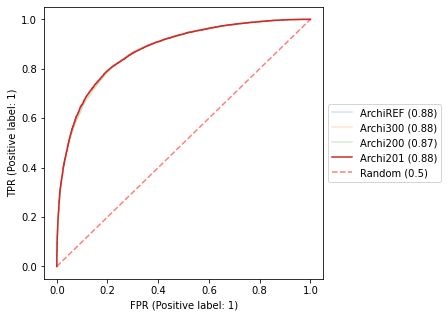

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



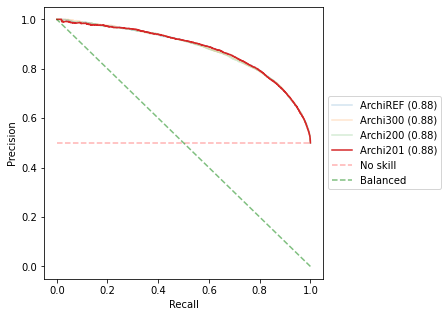

In [157]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [158]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 11s 17ms/step
The best Accuracy score (0.7938) for this model is reached with a threshold of 0.486


625/625 [==============================] - 11s 17ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi201 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8760
                  F1 : 0.7946
            ACCURACY : 0.7964
           PRECISION : 0.8019
              RECALL : 0.7874
   AVERAGE_PRECISION : 0.8789

       TRAINING-TIME : 685.3491
      INFERENCE-TIME : 10.7642

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.81      0.80     10000
Prediction = 1       0.80      0.79      0.79     10000

      accuracy    

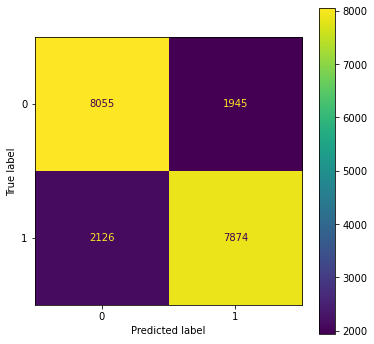

In [159]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [160]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [161]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156
6,Archi200,0.500,None,0.874350,0.877319,0.792187,0.79360,0.797648,0.7868,7868,8004,1996,2132,219.169741,6.572566
7,Archi200 [w. threshold],0.487,None,0.874350,0.877319,0.794013,0.79355,0.792235,0.7958,7958,7913,2087,2042,219.169741,7.033490
8,Archi300,0.500,None,0.875135,0.878472,0.789605,0.79315,0.803374,0.7763,7763,8100,1900,2237,219.337739,5.728404
9,Archi300 [w. threshold],0.522,None,0.875135,0.878472,0.785224,0.79185,0.811041,0.7610,7610,8227,1773,2390,219.337739,6.568661


---
## 2.7 `Archi-202` Bi-LSTM 64 + Dense 24 <a class="anchor" id="ARCHI_202"></a> [⇪](#menu)

In [163]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [164]:
model_name = "Archi202"
model, archi_desc = architecture202("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [165]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 24)                3096      
                                                                 
 predictions (Dense)         (None, 1)                 25        
                                                                 
Total params: 4,138,801
Trainable params: 138,801
Non-trai

#### Définissons un logger DagsHub pour enregistrer notre essai

In [166]:
dagslogger = DAGsHubLogger()

In [167]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [168]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.7082
Epoch 1: val_accuracy improved from -inf to 0.76055, saving model to models/Archi202.keras
59/59 [==============================] - 49s 716ms/step - loss: 0.5575 - accuracy: 0.7082 - val_loss: 0.4893 - val_accuracy: 0.7606
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.7696
Epoch 2: val_accuracy improved from 0.76055 to 0.77540, saving model to models/Archi202.keras
59/59 [==============================] - 42s 713ms/step - loss: 0.4762 - accuracy: 0.7696 - val_loss: 0.4703 - val_accuracy: 0.7754
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.7808
Epoch 3: val_accuracy improved from 0.77540 to 0.77920, saving model to models/Archi202.keras
59/59 [==============================] - 44s 744ms/step - loss: 0.4591 - accuracy: 0.7808 - val_loss: 0.4615 - val_accuracy: 0.7792
Epoch 4/100
59/59 [=====================

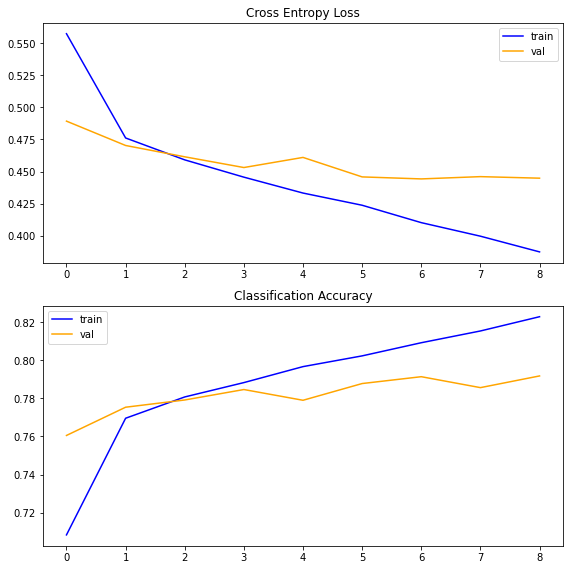

In [169]:
summarize_diagnostics(history)

### Evaluate

In [170]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [171]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 13s 18ms/step - loss: 0.4448 - accuracy: 0.7918


[0.4447997212409973, 0.7918499708175659]

In [172]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 2s 2s/step


array([[0.02653838],
       [0.9767058 ]], dtype=float32)

625/625 [==============================] - 11s 18ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi202 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8757
                  F1 : 0.7925
            ACCURACY : 0.7919
           PRECISION : 0.7900
              RECALL : 0.7950
   AVERAGE_PRECISION : 0.8782

       TRAINING-TIME : 399.2837
      INFERENCE-TIME : 11.3901

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.79      0.79     10000
Prediction = 1       0.79      0.80      0.79     10000

      accuracy    

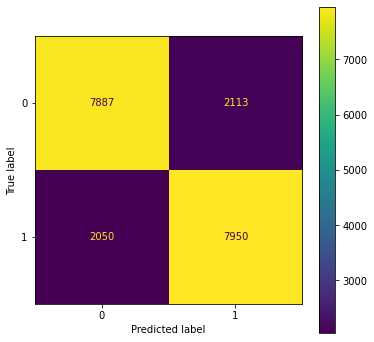

--- ROC AUC ---------------------------------------------------------------------------------------- 



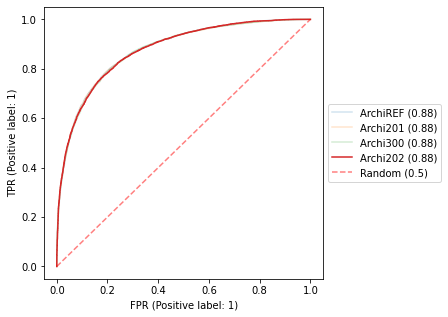

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



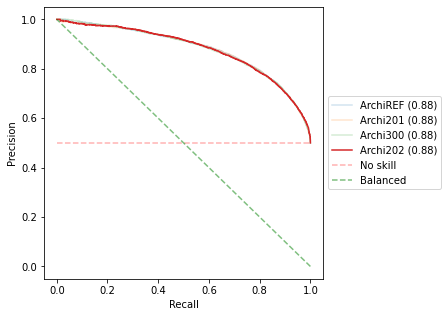

In [173]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [174]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 12s 19ms/step
The best Accuracy score (0.79425) for this model is reached with a threshold of 0.5650000000000001


625/625 [==============================] - 11s 18ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi202 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8757
                  F1 : 0.7845
            ACCURACY : 0.7925
           PRECISION : 0.8160
              RECALL : 0.7553
   AVERAGE_PRECISION : 0.8782

       TRAINING-TIME : 399.2837
      INFERENCE-TIME : 11.5675

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.83      0.80     10000
Prediction = 1       0.82      0.76      0.78     10000

      accuracy    

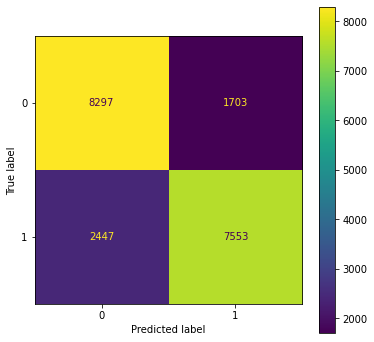

In [175]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [176]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [177]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156
6,Archi200,0.500,None,0.874350,0.877319,0.792187,0.79360,0.797648,0.7868,7868,8004,1996,2132,219.169741,6.572566
7,Archi200 [w. threshold],0.487,None,0.874350,0.877319,0.794013,0.79355,0.792235,0.7958,7958,7913,2087,2042,219.169741,7.033490
8,Archi300,0.500,None,0.875135,0.878472,0.789605,0.79315,0.803374,0.7763,7763,8100,1900,2237,219.337739,5.728404
9,Archi300 [w. threshold],0.522,None,0.875135,0.878472,0.785224,0.79185,0.811041,0.7610,7610,8227,1773,2390,219.337739,6.568661


---
## 2.8 `Archi-301` Bi-GRU 64 + Dropout 0.5 <a class="anchor" id="ARCHI_301"></a> [⇪](#menu)

In [179]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [180]:
model_name = "Archi301"
model, archi_desc = architecture301("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [181]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              102144    
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 4,102,273
Trainable params: 102,273
Non-trai

#### Définissons un logger DagsHub pour enregistrer notre essai

In [182]:
dagslogger = DAGsHubLogger()

In [183]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [184]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5909 - accuracy: 0.6736
Epoch 1: val_accuracy improved from -inf to 0.74945, saving model to models/Archi301.keras
59/59 [==============================] - 46s 663ms/step - loss: 0.5909 - accuracy: 0.6736 - val_loss: 0.5073 - val_accuracy: 0.7495
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.4929 - accuracy: 0.7620
Epoch 2: val_accuracy improved from 0.74945 to 0.77390, saving model to models/Archi301.keras
59/59 [==============================] - 36s 607ms/step - loss: 0.4929 - accuracy: 0.7620 - val_loss: 0.4725 - val_accuracy: 0.7739
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4695 - accuracy: 0.7754
Epoch 3: val_accuracy improved from 0.77390 to 0.78125, saving model to models/Archi301.keras
59/59 [==============================] - 36s 605ms/step - loss: 0.4695 - accuracy: 0.7754 - val_loss: 0.4617 - val_accuracy: 0.7812
Epoch 4/100
59/59 [=====================

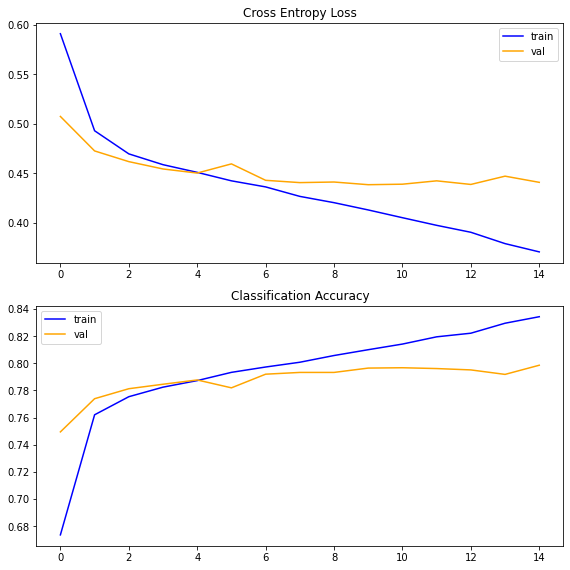

In [185]:
summarize_diagnostics(history)

### Evaluate

In [186]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [187]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 10s 13ms/step - loss: 0.4408 - accuracy: 0.7986


[0.44079121947288513, 0.798550009727478]

In [188]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 2s 2s/step


array([[0.06511527],
       [0.9678545 ]], dtype=float32)

625/625 [==============================] - 9s 14ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi301 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8799
                  F1 : 0.7943
            ACCURACY : 0.7985
           PRECISION : 0.8115
              RECALL : 0.7778
   AVERAGE_PRECISION : 0.8816

       TRAINING-TIME : 542.1735
      INFERENCE-TIME : 8.8780

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.82      0.80     10000
Prediction = 1       0.81      0.78      0.79     10000

      accuracy      

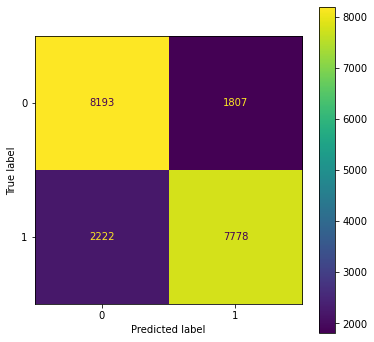

--- ROC AUC ---------------------------------------------------------------------------------------- 



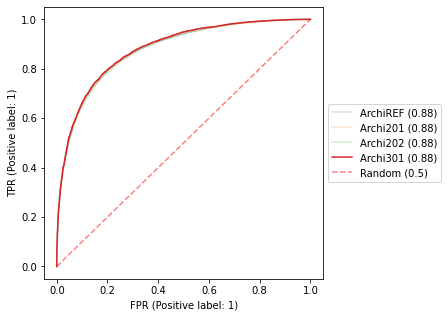

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



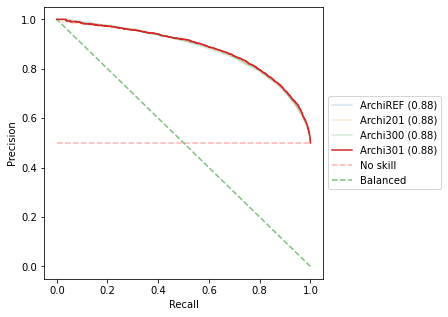

In [189]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [190]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 9s 14ms/step
The best Accuracy score (0.79875) for this model is reached with a threshold of 0.489


625/625 [==============================] - 8s 13ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi301 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8799
                  F1 : 0.7956
            ACCURACY : 0.7984
           PRECISION : 0.8068
              RECALL : 0.7847
   AVERAGE_PRECISION : 0.8816

       TRAINING-TIME : 542.1735
      INFERENCE-TIME : 8.4082

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.81      0.80     10000
Prediction = 1       0.81      0.78      0.80     10000

      accuracy      

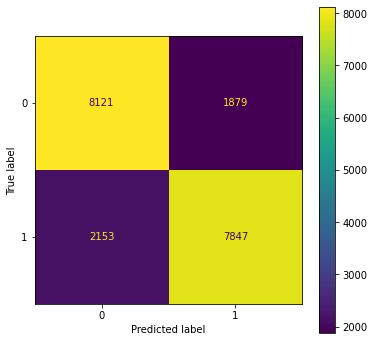

In [191]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [192]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [193]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156
6,Archi200,0.500,None,0.874350,0.877319,0.792187,0.79360,0.797648,0.7868,7868,8004,1996,2132,219.169741,6.572566
7,Archi200 [w. threshold],0.487,None,0.874350,0.877319,0.794013,0.79355,0.792235,0.7958,7958,7913,2087,2042,219.169741,7.033490
8,Archi300,0.500,None,0.875135,0.878472,0.789605,0.79315,0.803374,0.7763,7763,8100,1900,2237,219.337739,5.728404
9,Archi300 [w. threshold],0.522,None,0.875135,0.878472,0.785224,0.79185,0.811041,0.7610,7610,8227,1773,2390,219.337739,6.568661


---
## 2.9 `Archi-302` Bi-GRU 64 + Dense 24 <a class="anchor" id="ARCHI_302"></a> [⇪](#menu)

In [195]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [196]:
model_name = "Archi302"
model, archi_desc = architecture302("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [197]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              102144    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 24)                3096      
                                                                 
 predictions (Dense)         (None, 1)                 25        
                                                                 
Total params: 4,105,265
Trainable params: 105,265
Non-trai

#### Définissons un logger DagsHub pour enregistrer notre essai

In [198]:
dagslogger = DAGsHubLogger()

In [199]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [200]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.6986
Epoch 1: val_accuracy improved from -inf to 0.75775, saving model to models/Archi302.keras
59/59 [==============================] - 46s 669ms/step - loss: 0.5653 - accuracy: 0.6986 - val_loss: 0.4922 - val_accuracy: 0.7577
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.4736 - accuracy: 0.7721
Epoch 2: val_accuracy improved from 0.75775 to 0.77615, saving model to models/Archi302.keras
59/59 [==============================] - 38s 649ms/step - loss: 0.4736 - accuracy: 0.7721 - val_loss: 0.4673 - val_accuracy: 0.7761
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.7839
Epoch 3: val_accuracy improved from 0.77615 to 0.78275, saving model to models/Archi302.keras
59/59 [==============================] - 39s 660ms/step - loss: 0.4563 - accuracy: 0.7839 - val_loss: 0.4579 - val_accuracy: 0.7828
Epoch 4/100
59/59 [=====================

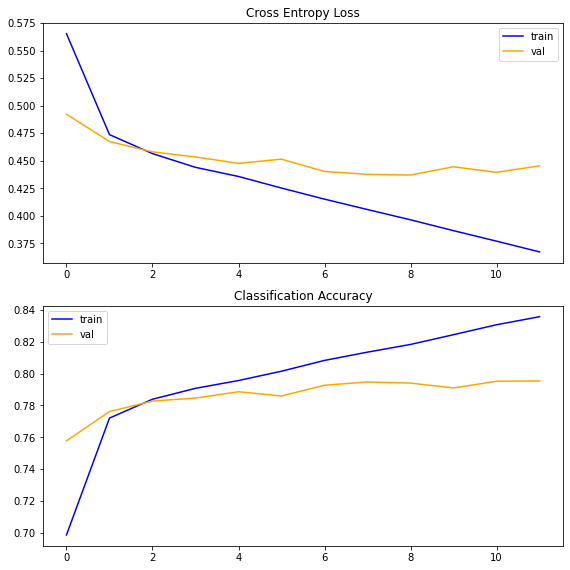

In [201]:
summarize_diagnostics(history)

### Evaluate

In [202]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [203]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 10s 13ms/step - loss: 0.4453 - accuracy: 0.7954


[0.4452706575393677, 0.7954000234603882]

In [204]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 2s 2s/step


array([[0.03186992],
       [0.98675865]], dtype=float32)

625/625 [==============================] - 8s 13ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi302 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8797
                  F1 : 0.7980
            ACCURACY : 0.7954
           PRECISION : 0.7880
              RECALL : 0.8082
   AVERAGE_PRECISION : 0.8818

       TRAINING-TIME : 446.3985
      INFERENCE-TIME : 8.4941

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.78      0.79     10000
Prediction = 1       0.79      0.81      0.80     10000

      accuracy      

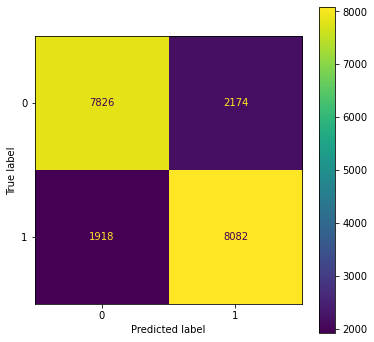

--- ROC AUC ---------------------------------------------------------------------------------------- 



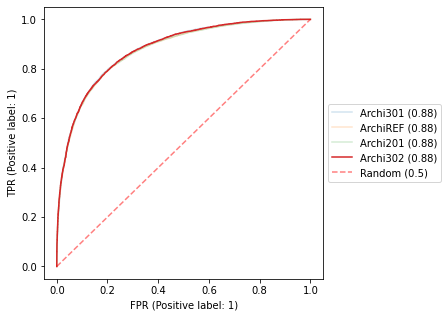

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



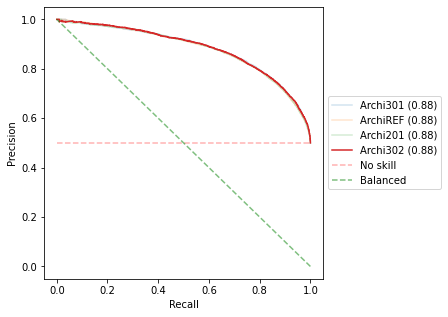

In [205]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [206]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 8s 13ms/step
The best Accuracy score (0.798) for this model is reached with a threshold of 0.593


625/625 [==============================] - 9s 14ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi302 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8797
                  F1 : 0.7865
            ACCURACY : 0.7944
           PRECISION : 0.8182
              RECALL : 0.7572
   AVERAGE_PRECISION : 0.8818

       TRAINING-TIME : 446.3985
      INFERENCE-TIME : 8.7875

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.83      0.80     10000
Prediction = 1       0.82      0.76      0.79     10000

      accuracy      

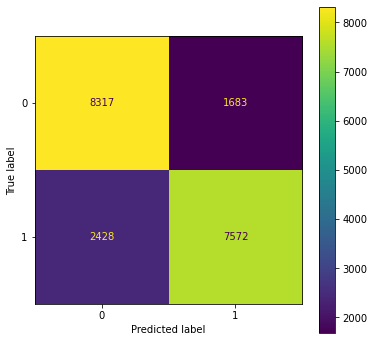

In [207]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [208]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [209]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156
6,Archi200,0.500,None,0.874350,0.877319,0.792187,0.79360,0.797648,0.7868,7868,8004,1996,2132,219.169741,6.572566
7,Archi200 [w. threshold],0.487,None,0.874350,0.877319,0.794013,0.79355,0.792235,0.7958,7958,7913,2087,2042,219.169741,7.033490
8,Archi300,0.500,None,0.875135,0.878472,0.789605,0.79315,0.803374,0.7763,7763,8100,1900,2237,219.337739,5.728404
9,Archi300 [w. threshold],0.522,None,0.875135,0.878472,0.785224,0.79185,0.811041,0.7610,7610,8227,1773,2390,219.337739,6.568661


---
## 2.10 `Archi-401` Bi-LSTM 32 + Dense 10 <a class="anchor" id="ARCHI_401"></a> [⇪](#menu)

In [211]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [212]:
model_name = "Archi401"
model, archi_desc = architecture401("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [213]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               59648     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
 predictions (Dense)         (None, 1)                 11        
                                                                 
Total params: 4,060,309
Trainable params: 60,309
Non-train

#### Définissons un logger DagsHub pour enregistrer notre essai

In [214]:
dagslogger = DAGsHubLogger()

In [215]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [216]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.7035
Epoch 1: val_accuracy improved from -inf to 0.75205, saving model to models/Archi401.keras
59/59 [==============================] - 32s 421ms/step - loss: 0.5741 - accuracy: 0.7035 - val_loss: 0.5049 - val_accuracy: 0.7520
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.7625
Epoch 2: val_accuracy improved from 0.75205 to 0.77125, saving model to models/Archi401.keras
59/59 [==============================] - 24s 401ms/step - loss: 0.4862 - accuracy: 0.7625 - val_loss: 0.4770 - val_accuracy: 0.7713
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.7763
Epoch 3: val_accuracy improved from 0.77125 to 0.77915, saving model to models/Archi401.keras
59/59 [==============================] - 25s 425ms/step - loss: 0.4659 - accuracy: 0.7763 - val_loss: 0.4654 - val_accuracy: 0.7792
Epoch 4/100
59/59 [=====================

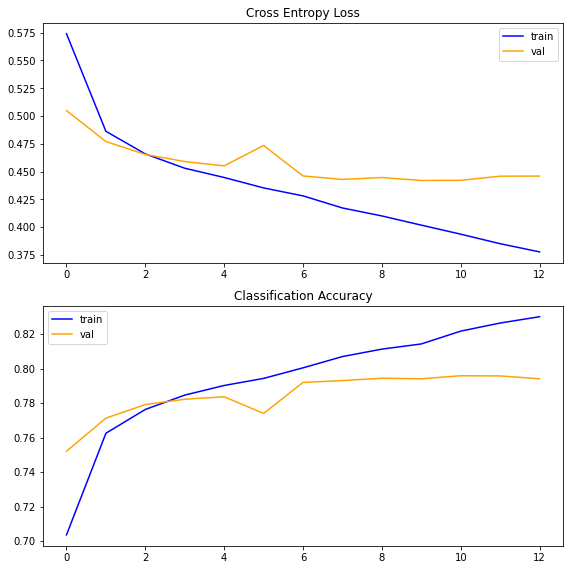

In [217]:
summarize_diagnostics(history)

### Evaluate

In [218]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [219]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 11s 14ms/step - loss: 0.4421 - accuracy: 0.7958


[0.44206488132476807, 0.7958499789237976]

In [220]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 2s 2s/step


array([[0.03856101],
       [0.9823493 ]], dtype=float32)

625/625 [==============================] - 9s 15ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi401 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8766
                  F1 : 0.7938
            ACCURACY : 0.7958
           PRECISION : 0.8018
              RECALL : 0.7860
   AVERAGE_PRECISION : 0.8803

       TRAINING-TIME : 349.6920
      INFERENCE-TIME : 9.3229

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.81      0.80     10000
Prediction = 1       0.80      0.79      0.79     10000

      accuracy      

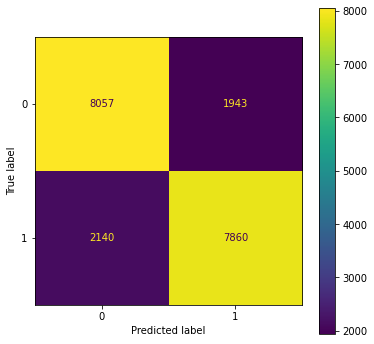

--- ROC AUC ---------------------------------------------------------------------------------------- 



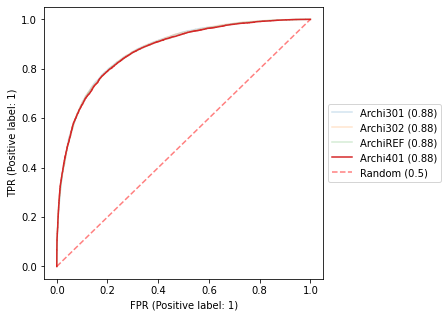

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



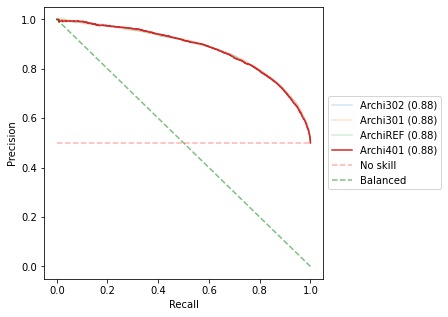

In [221]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [222]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 9s 14ms/step
The best Accuracy score (0.79325) for this model is reached with a threshold of 0.5


625/625 [==============================] - 9s 14ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi401 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8766
                  F1 : 0.7938
            ACCURACY : 0.7958
           PRECISION : 0.8018
              RECALL : 0.7860
   AVERAGE_PRECISION : 0.8803

       TRAINING-TIME : 349.6920
      INFERENCE-TIME : 9.0131

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.81      0.80     10000
Prediction = 1       0.80      0.79      0.79     10000

      accuracy      

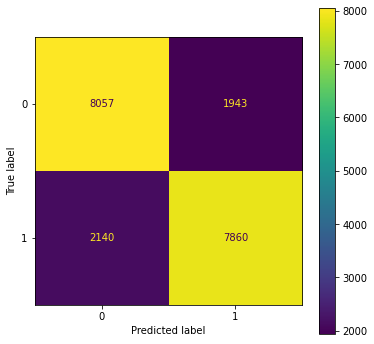

In [223]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [224]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [225]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156
6,Archi200,0.500,None,0.874350,0.877319,0.792187,0.79360,0.797648,0.7868,7868,8004,1996,2132,219.169741,6.572566
7,Archi200 [w. threshold],0.487,None,0.874350,0.877319,0.794013,0.79355,0.792235,0.7958,7958,7913,2087,2042,219.169741,7.033490
8,Archi300,0.500,None,0.875135,0.878472,0.789605,0.79315,0.803374,0.7763,7763,8100,1900,2237,219.337739,5.728404
9,Archi300 [w. threshold],0.522,None,0.875135,0.878472,0.785224,0.79185,0.811041,0.7610,7610,8227,1773,2390,219.337739,6.568661


---
## 2.11 `Archi-402` Bi-LSTM 64 Seq + Dropout 0.2 + Bi-LSTM 32 + Dropout 0.2 + Dense 64 + Dropout 0.1 <a class="anchor" id="ARCHI_402"></a> [⇪](#menu)

In [227]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [228]:
model_name = "Archi402"
model, archi_desc = architecture402("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [229]:
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_GloVe_Twitter_200  (None, None, 200)        4000000   
 d (Embedding)                                                   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        135680    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                          

#### Définissons un logger DagsHub pour enregistrer notre essai

In [230]:
dagslogger = DAGsHubLogger()

In [231]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [232]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.7014
Epoch 1: val_accuracy improved from -inf to 0.76165, saving model to models/Archi402.keras
59/59 [==============================] - 94s 1s/step - loss: 0.5712 - accuracy: 0.7014 - val_loss: 0.4944 - val_accuracy: 0.7617
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.7674
Epoch 2: val_accuracy improved from 0.76165 to 0.77370, saving model to models/Archi402.keras
59/59 [==============================] - 76s 1s/step - loss: 0.4846 - accuracy: 0.7674 - val_loss: 0.4714 - val_accuracy: 0.7737
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.7779
Epoch 3: val_accuracy improved from 0.77370 to 0.78335, saving model to models/Archi402.keras
59/59 [==============================] - 76s 1s/step - loss: 0.4650 - accuracy: 0.7779 - val_loss: 0.4601 - val_accuracy: 0.7833
Epoch 4/100
59/59 [==============================

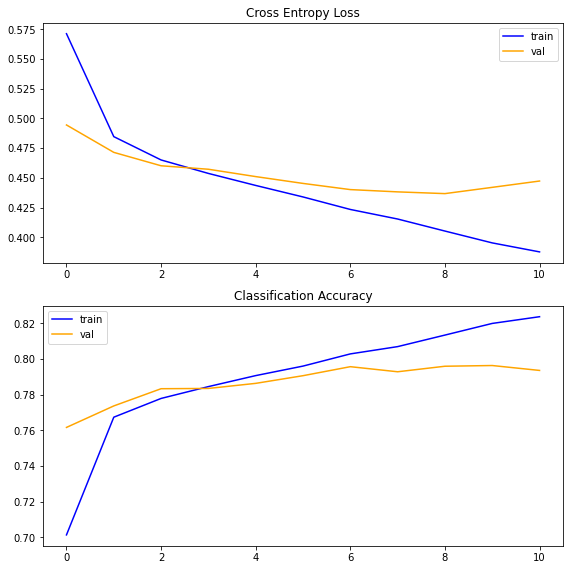

In [233]:
summarize_diagnostics(history)

### Evaluate

In [234]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [235]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 24s 30ms/step - loss: 0.4420 - accuracy: 0.7964


[0.44195541739463806, 0.7963500022888184]

In [236]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

1/1 [==============================] - 5s 5s/step


array([[0.07221694],
       [0.9740642 ]], dtype=float32)

625/625 [==============================] - 20s 32ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi402 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8797
                  F1 : 0.7921
            ACCURACY : 0.7964
           PRECISION : 0.8091
              RECALL : 0.7758
   AVERAGE_PRECISION : 0.8814

       TRAINING-TIME : 851.4995
      INFERENCE-TIME : 20.2483

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.82      0.80     10000
Prediction = 1       0.81      0.78      0.79     10000

      accuracy    

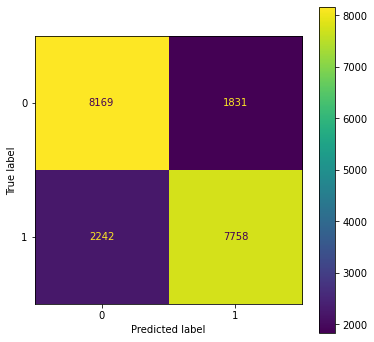

--- ROC AUC ---------------------------------------------------------------------------------------- 



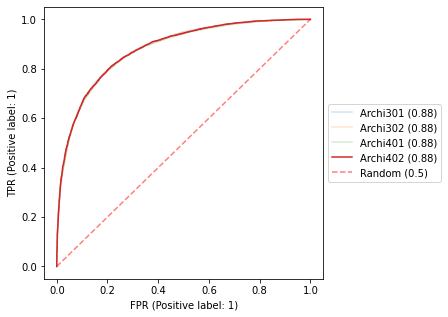

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



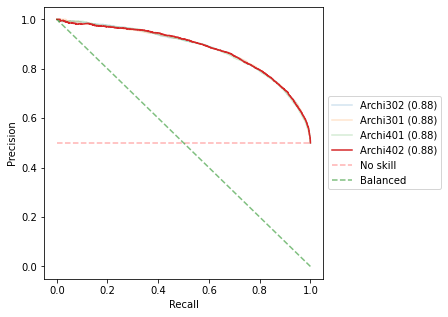

In [237]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [238]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

625/625 [==============================] - 19s 30ms/step
The best Accuracy score (0.799) for this model is reached with a threshold of 0.531


625/625 [==============================] - 19s 30ms/step
----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Archi402 [w. threshold] ------------------------------------------------------------------------

             ROC_AUC : 0.8797
                  F1 : 0.7862
            ACCURACY : 0.7945
           PRECISION : 0.8193
              RECALL : 0.7556
   AVERAGE_PRECISION : 0.8814

       TRAINING-TIME : 851.4995
      INFERENCE-TIME : 19.0702

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.83      0.80     10000
Prediction = 1       0.82      0.76      0.79     10000

      accuracy    

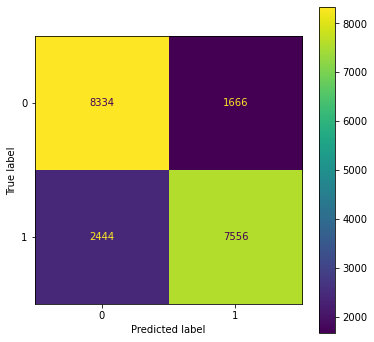

In [239]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [240]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [241]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,ArchiREF,0.500,None,0.876522,0.879489,0.790788,0.79560,0.809853,0.7726,7726,8186,1814,2274,339.848347,9.503837
1,ArchiREF [w. threshold],0.468,None,0.876522,0.879489,0.795251,0.79565,0.796808,0.7937,7937,7976,2024,2063,339.848347,8.022760
2,Archi000,0.500,None,0.504975,0.503525,0.539456,0.51005,0.508912,0.5739,5739,4462,5538,4261,6.366710,0.823483
3,Archi000 [w. threshold],0.453,None,0.504975,0.503525,0.540563,0.50985,0.508688,0.5767,5767,4430,5570,4233,6.366710,0.781419
4,Archi100,0.500,None,0.846918,0.847525,0.770271,0.77065,0.771546,0.7690,7690,7723,2277,2310,105.579530,4.189630
5,Archi100 [w. threshold],0.556,None,0.846918,0.847525,0.755625,0.76650,0.792536,0.7220,7220,8110,1890,2780,105.579530,3.968156
6,Archi200,0.500,None,0.874350,0.877319,0.792187,0.79360,0.797648,0.7868,7868,8004,1996,2132,219.169741,6.572566
7,Archi200 [w. threshold],0.487,None,0.874350,0.877319,0.794013,0.79355,0.792235,0.7958,7958,7913,2087,2042,219.169741,7.033490
8,Archi300,0.500,None,0.875135,0.878472,0.789605,0.79315,0.803374,0.7763,7763,8100,1900,2237,219.337739,5.728404
9,Archi300 [w. threshold],0.522,None,0.875135,0.878472,0.785224,0.79185,0.811041,0.7610,7610,8227,1773,2390,219.337739,6.568661


---
## 2.12 `Archi-403` Dense 128 + Dropout 0.2 + Dense 64 + Dropout 0.2 + Dense 32 + Dropout 0.1 <a class="anchor" id="ARCHI_403"></a> [⇪](#menu)

In [ ]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
    name="embedding_GloVe_Twitter_200d",
)

In [ ]:
model_name = "Archi403"
model, archi_desc = architecture403("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [ ]:
model.summary()

#### Définissons un logger DagsHub pour enregistrer notre essai

In [ ]:
dagslogger = DAGsHubLogger()

In [ ]:
save_hyperparameters_to_dagshub(dagslogger, model_name, archi_desc, get_layers_for_dagshub(model), batch_size, data_work.shape[0])

### Train model

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=100, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"{model_name}"),
        verbose=1,
)
train_time = time.perf_counter() - t0

In [ ]:
summarize_diagnostics(history)

### Evaluate

In [ ]:
model = keras.models.load_model(f"models/{model_name}.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
_ = get_scores(
    model_name,
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=0.5,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
)

#### Trouvons le meilleur seuil de séparation pour les prédiction (sur la base du F1 score)

In [ ]:
acc_value, best_threshold = find_best_threshold(model, X_valid_ready, y_valid, accuracy_score)
print(f"The best Accuracy score ({acc_value}) for this model is reached with a threshold of {best_threshold}")

In [ ]:
scores = get_scores(
    f"{model_name} [w. threshold]",
    model=model,
    X_ref=X_test_ready,
    y_ref=y_test, 
    threshold=best_threshold,
    # y_pred=y_preds, 
    # y_pred_proba=y_preds_proba, 
    training_time=train_time, 
    # inference_time=inf_time, 
    dagslogger=dagslogger,
    register=True,
    show_roccurves=False,
)

#### Enregistrons les scores pour DagsHub

In [ ]:
save_metrics_to_dagshub(dagslogger, scores, best_threshold, history)
dagslogger.save() 
dagslogger.close()

### Compare

In [ ]:
from classification_utils import scores_df
scores_df

---
## 2.13 Comparaison des `scores` avec les différentes architectures <a class="anchor" id="ARCHI_scores"></a> [⇪](#menu)

In [ ]:
from classification_utils import scores_df

In [ ]:
scores_df.sort_values(['ROC AUC'], ascending=False)

In [ ]:
scores_df.sort_values(['Accuracy'], ascending=False)

In [ ]:
import FreeMobileSMS as sms
sms.send(stop=False)